In [1]:
#| default_exp cell_data
from nbdev.showdoc import show_doc
from utilities.ipynb_docgen import *

%reload_ext autoreload
%autoreload 2
! date

Thu Mar  2 23:53:14 PST 2023


## Creating and fitting cells

As set out in Kerr, we create "cells" by binning in time to form light curves. For each cell, we determine its likelihood function, which is then optimized to estimate the relative signal rate for that duration. 

Eqn. 2 of Kerr presents the log likelihood as a function of the incremental relative flux $\alpha$ (with $\beta=0$). The log likelihood for a cell is

$$ \displaystyle\log\mathcal{L}(\alpha)\ = \sum_w  \log \big( 1 + \alpha\ w \big) - \alpha\ S \tag{1} , $$

where the sum is over the photon weights $w$ for that cell, and $S$ is the expected value for sum of weights, determined from the total sum and the fraction of the energy-weighted exposure for the cell,

$$ S =  \frac{f_{cell}}{ f_{total}}\ \sum{w},  $$
where $f$ represents the energy-weighted exposure.

*Fermi* data is broken into distinct _runs_, corresponding at most to a single orbit. The effective area, or $\frac{df}{dt}$, varies by a factor of 2 or 3 for each 90-min orbit, is typically  $ 3 000\ \mathrm{cm}^2$, or $0.3\ \mathrm{m^2}$. This is measured in 30-s intervals. Exposure is the sum, for each interval in contained in the cell, of the effective area times livetime in the direcion of the source. Since it depends on energy, the Kerr strategy is to perform a weighted average with a spectrum. This can be improved on, see below.

The value of $\alpha$,  $\hat{\alpha}$, which maximizes the likelihood for the cell is the solution to 

$$ \sum_{w} \frac{w}{1+\hat{\alpha}\ w} = S $$

So that $\hat{\alpha}=0$ corresponds to $\sum w=  S$, as expected if the cell's flux is the same as the average. 

The Hessian, or inverse variance, is  
$$ -\frac{d^2\ \log(\mathcal{L})}{d\ \alpha^2} = \sum_{w} \frac{w^2}{(1+\hat{\alpha}\ w)^2}$$ 

### Approximate the log if $\alpha \times \omega$ is small

Kerr uses this for the frequency derivation. Let $W=\sum w$ and $U=\sum w^2$. Then the  cell's likelihood is

$$ \displaystyle\log\mathcal{L}(\alpha)\ \approx   \alpha\ \ (W-S) - \tfrac{1}{2} \alpha^2\ U ,  \tag{2}$$


and the maximum likelihood solution is analytic: $\hat{\alpha} =  (W-S)/U$
with the inverse variance simply $U$.


### Accounting for spectral dependence

The development above does not consider energy. The sum over weights includes photons of all energies, and the coresponding exposure uses a weighted average of the energy-dependent effective area. The Kerr 
application uses a power-law spectral shape for this--since we have the actual spectrum available, we can use it instead. 

We bin energy into four bands per decade. This modification breaks up a call into eight sub-cells with the
same $\alpha$ value.

Also, the development above determines the _count_ flux per cell, that is, simply counting photons.  An improvement wmeasures the energy flux as well, or perhaps a spectral index factor as a factor for the assumed spectrum. 

Each photon has a _band_ index, indicating its type as Front or Back, and its energy band, one of 16 from 100 MeV to 1 TeV. (Although we only use 8 bands, up to 10 GeV). To use this information, we need the corresponding exposure. 

Currently the `exposure` DataFrame has, for each 30-s time interval, the exposure as calculated for the assumed spectrum. This is extended to provide the exposure per energy band.  

Let $l$ be the energy index. It represents a logarithmic derivative of the energy. Replace $\alpha$ with $\alpha+\zeta l$ in Equ. (2): Then the solution for $\zeta$ is

$$\zeta = \frac{\sum_l(W_l-S_l-\alpha U_l)}{\sum_l l U_l} $$

## Implementation

The class `CellData` is created with the list of photons and exposure history for the source. It is created with 
a `time_bins` argument to describe the binning, generating a list, accessible via the property `cells` with the cell information needed to calculate the likelihood function.

Its `view` member function is used to create a new binning, by making a copy of the `CellData` object with the new binning. 

The default binning is sequential, with start, stop, and step values. Units for start and stop are MJD, so step is in days. The conventions for interpeting the three numbers (0,0,7), the default, is all weeks from the start of data taking. This is implemented by the function `time_bin_edges`.

The function `partition_cells` is used to create a set of unequal-sized cells from a BB partition.




#### Special phased bins

To study long-term, many days, variations in the flux, perhaps due to systematics in the exposure, we implement a folded binning version, specified by start, period, and number of cells.

In [2]:
#| export
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('figure', facecolor='white')
from wtlike.config import *
from wtlike.sources import *
from wtlike.source_data import *
from wtlike.loglike import LogLike, PoissonRep, poisson_tolerance

In [3]:
#| export  
def time_bin_edges(config, exposure, tbin=None):
    """Return an interleaved array of time bin, or cell start/stop values

    - exposure -- the weighted exposure table derived from the spacecraft info and the source. Used only
        to establish nominal start/stop
    - tbin: an array (a,b,d), default config.time_bins to specify binning

        interpretation of a, b, d:

        a:  if > 50000, interpret as MJD for start
            if < 0, back from stop
            otherwise, offset from exposure start

        b:  if > 50000, interpret MJD value for stop
            if > 0, increment from start
            otherwise, offset from exposure stop

        d : if positive, the day bin size
            if 0; return contiguous bins


    """
    # nominal total range, MJD edges
    start = np.round(exposure.start.values[0])
    stop =  np.round(exposure.stop.values[-1])

    a, b, step = tbin if tbin is not None else config.time_bins

    if a>50000: start=a
    elif a<0: start = stop+a
    else : start += a

    if b>50000: stop=b
    elif b>0: stop = start+b
    else: stop += b

    if step<=0:
        return contiguous_bins(exposure.query(f'{start}<start<{stop}'),)

    # adjust stop
    nbins = int((stop-start)/step)
    assert nbins>0, 'Bad binning: no bins'
    stop = start+(nbins)*step
    u =  np.linspace(start,stop, nbins+1 )

    # make an interleaved start/stop array
    v = np.empty(2*nbins, float)
    v[0::2] = u[:-1]
    v[1::2] = u[1:]
    return v

In [4]:
show_doc(time_bin_edges)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/exposure.py#L15){target="_blank" style="float:right; font-size:smaller"}

### time_bin_edges

>      time_bin_edges (config, exposure, tbin=None)

Return an interleaved array of time bin, or cell start/stop values

- exposure -- the weighted exposure table derived from the spacecraft info and the source. Used only
    to establish nominal start/stop
- tbin: an array (a,b,d), default config.time_bins to specify binning

    interpretation of a, b, d:

    a:  if > 50000, interpret as MJD for start
        if < 0, back from stop
        otherwise, offset from exposure start

    b:  if > 50000, interpret MJD value for stop
        if > 0, increment from start
        otherwise, offset from exposure stop

    d : if positive, the day bin size
        if 0; return contiguous bins

In [5]:
#| export
def contiguous_bins(exposure, min_gap=20, min_duration=600):

    """ return a start/stop interleaved array for contiguous intervals

    """

    stop = exposure.stop.values
    start = exposure.start.values

    # interleave  the starts and stops
    ssint = np.empty(2*len(start))
    ssint[0::2] = start
    ssint[1::2] = stop

    # Tag the (stpp,start) pairs < 10 sec as  not adjacent
    not_adjacent = np.diff(ssint)[1::2] > min_gap/(24*3600) ;
    #print(f'{sum(not_adjacent)} (start,stop) pairs are not closer than {min_gap} s')

    # make a mask, keep ends
    mask = np.empty(2*len(start), bool)
    mask[0] = mask[-1] = True
    #

    # insert into mask -- keep only the (stop,start) pairs  which are not adjacent
    mask[1:-2:2] = not_adjacent
    mask[2:-1:2] = not_adjacent

    # apply mask, split into start and stop
    keep = ssint[mask]
    return keep

In [6]:
#| export
class CellData(SourceData):
    r"""Manage a set of cells generated from a data set

        Invoke superclass to load photon data and exposure for the source.

        * time_bins, default config.time_bins. If specified, set week_range and bypass cache.

        The `e` cell entry is the weighted exposure for the cell in units $cm^2\ Ms$.
        """

    def __init__(self, *pars, **kwargs):
        """
        """

        bins = kwargs.pop('time_bins', None)
        if bins is not None:
            if bins[0]>50000 and bins[1]>50000:
                # kluge to at least accept (0,0) in constructor
                week_range = (mission_week(bins[0]), mission_week(bins[1]))
                kwargs.update(week_range=week_range)
                setweeks=True
        else:
            bins = Config().time_bins
            setweeks=False

        #  load source data

        super().__init__(*pars, **kwargs )
        if self.config.verbose>1 and setweeks:
            print(f'CellData: set week range to {week_range}')

        self.rebin(bins)
        self.parent = None

    def rebin(self, newbins):
        """bin, or rebin
        """
        photon_data = self.photons
        self.time_bins = newbins
        self.cell_edges = edges = time_bin_edges(self.config, self.exposure, newbins)
        if self.config.verbose>0:
            step = newbins[2]
            self.step_name = 'orbit-based' if step<=0 else bin_size_name(step)
            print(f'CellData.rebin: Bin photon data into {int(len(edges)/2)} {self.step_name}'\
                  f' bins from {edges[0]:.1f} to {edges[-1]:.1f}')
        # note need to take care of interleave
        #self.binexp = self.binned_exposure( edges ) [0::2]

        self.make_cells()

    def get_exposure_per_cell(self, exposure_factor=1e-6, set_costh=False):
        """
        Return a dict of arrays per cell:
        - exp -- exposure, in cm^2 Ms units, if exposure_factor==1e-6
        - costh -- mean cos theta per cell if set_costh is set
        - exp_energy if exp_fract in the exposure DF, set exposure energy

        Note: total exposure vs. energy is:
            t =df.apply(lambda r: np.array(r.exp * np.array(r.exp_fract), float), axis=1).values
            u = np.vstack(t)
        """
        exp = self.exposure.exp.values

        # the cell index list
        eci = np.searchsorted(self.exposure.stop, self.cell_edges).reshape(len(self.cell_edges)//2,2)
        cell_exp = np.array([exp[slice(*ecx)].sum()*exposure_factor for ecx in eci], np.float32) #np.float32)
        if set_costh:
            costh = self.exposure.cos_theta.values
            cell_costh =np.array([costh[slice(*ecx)].mean() for ecx in eci], np.float32)
        else: cell_costh=None

        ef = self.exposure.get('exp_fract', None)
        if ef is not None:
            efa = np.array([np.array(x,float) for x in ef])
            efe = efa.T * exp
            cee = np.array([efe.T[slice(*ecx)].sum(axis=0)*exposure_factor for ecx in eci], np.float32)
        else:
            cee = None
        return dict(exp=cell_exp, costh=cell_costh, exp_energy= cee)

    def get_weights_per_cell(self):
        """
        Return a list of arrays of the weights per cell
        """
        wts = self.photons.weight.values.astype(np.float32)
        # use photon times to get cell index range into photon list
        photon_cell = np.searchsorted(self.photons.time, self.cell_edges).reshape(len(self.cell_edges)//2,2)
        return  [wts[slice(*cell)] for cell in photon_cell]

    def make_cells(self, exposure_factor=1e-6, set_costh=False):
        r"""
        Generate a "cells" DataFrame, binning according to self.cell_edges

        - exposure_factor --  recast exposure as cm^2 * Ms if `exposure_factor`==1e-6`
        - set_costh [False] -- if set, include mean cos(theta) in cell info as `ctm`.

        Thus the `e` cell entry is the weighted exposure for the cell in units $\mathrm{cm^2 Ms}$.
        """
        # ncells = len(self.cell_edges)//2
        start,stop = self.cell_edges[0::2], self.cell_edges[1::2]
        center = (start+stop)/2
        width = (stop-start)
        etot = self.exptot*exposure_factor
        Sk, Bk = self.S/etot, self.B/etot

        # invoke the helper functions to make lists to incorporate
        weights = self.get_weights_per_cell()
        ec = self.get_exposure_per_cell(exposure_factor, set_costh)
        cell_exp, cell_costh = ec['exp'], ec['costh']

        self.cells = pd.DataFrame.from_dict(dict(
            t=center,
            tw=width,
            e = cell_exp,
            n = [len(w) for w in weights],
            w = weights,
            S = cell_exp*Sk,
            B = cell_exp*Bk,
        ))
        if set_costh:
            self.cells.iloc[:,'ctm']= cell_costh;

    def update(self): pass # virtual

    def view(self, *pars, exp_min=None, no_update=False):
        """
        Return a "view", a copy of this instance with a perhaps a different set of cells

        - pars -- start, stop, step  to define new binning. Or start, step, or just step
           start and stop are either MJD values, or offsets from the start or stop.
           step -- the cell size in days, or if zero, orbit-based binning

        - exp_min [None] -- If specified, a different minimum exposure, in cm^2 Ms units to use for fitting
            from.

        - no_update -- avoid fitting the cells if invoked by LightCurve or WtLike
        """
        import copy
        if self.config.verbose>1:
            print(f'Making a view of the class {self.__class__}')
        r = copy.copy(self)
        if exp_min is not None: r.exp_min=exp_min

        if len(pars)==3:
            newbins = pars
        elif len(pars)==2: # new limits, same interval
            newbins = (pars[0], pars[1], self.time_bins[0])
        elif len(pars)==1:
            if type(pars[0])==tuple:
                newbins = pars[0]
            else:
                newbins = (self.time_bins[0], self.time_bins[1], pars[0])
        else:
            newbins=None

        if newbins is not None:
            r.rebin(newbins)
            if not no_update:
                r.update()

        r.parent = self
        return r

    def __repr__(self):
        return f'''{self.__class__}:
        {len(self.exposure):,} intervals from {self.cell_edges[0]:.1f} to {self.cell_edges[-1]:.1f} for source {self.source_name}
        S {self.S:.2f}  B {self.B:.2f} '''


    def concatenate( self ):
        """
        Combine this set of cells to one
        Return a dict with summed n, S, B, and concatenated w
        """

        cells = self.cells

        newcell = dict()

        if 't' in cells:
            ca, cb =cells.iloc[0], cells.iloc[-1]
            newcell.update(dict(t= 0.5*(ca.t-ca.tw/2 + cb.t+cb.tw/2), tw=cb.t-ca.t ))

        for col in ' n e S B'.split():
            newcell[col] = cells[col].sum()
        newcell['w'] = np.concatenate(list(cells.w.values))
        return newcell


    def full_likelihood(self ):
        """Concatentate all the cells, return a LogLike object
        """
        return LogLike(self.concatenate())

    def plot_concatenated(self, fignum=1, ax=None, **kwargs):
        """Likelihood function, with fit for concatenated data
        """
        lka = self.full_likelihood()
        fig,ax = plt.subplots(figsize=(4,2), num=fignum) if ax is None else (ax.figure, ax)
        lka.plot(ax=ax, **kwargs)
        return fig

    def x_view(self, corr_func):
        """ Return a new view with a modified exposure and same binning
        - corr_func -- exposure correction factor function of (MJD) time
        """
        import copy
        if self.config.verbose>0:
            print(f'CellData.x_view: Making a view of the class {self.__class__.__name__} with adjusted exposure')
        r = copy.copy(self)
        # need a copy of this object to change the exp field?
        r.exposure = copy.copy(self.exposure)
        t = r.exposure.stop
        mod_exp = r.exposure.exp * corr_func(t)
        r.exposure.drop('exp', axis=1)
        r.exposure.loc[:,'exp'] = mod_exp

        r.rebin(self.time_bins)
        r.update()
        r.parent = self

        return r

    def phase_view(self, period, nbins=25, reference='2008'):
        """ Return a "phase" view, in which the cell time binning is according to phase.

        * period -- 'year' | 'precession' | float
        * reference -- a UTC date for aligning the bins.
        """
        if type(reference)  in (int, float): 
            ref= reference
        elif type(reference)==str:
            ref = MJD(reference)
        else:
            raise Exception(f'CellData.phase_view: reference time {reference} is neigher float (MJD) nor str(UTC)')


        period = dict(precession=53.05, year=365.25).get(period, period)
        assert np.isreal(period), f'The specified period, "{name}", is not a real number'

        if self.config.verbose>0:
            print(f'CellData.phase_view: Create phase view, {nbins} bins with period {period} days.')

        # helper function that returns the bin number as a float in [0,period)
        binner = lambda t: np.mod(t-ref,period)/period * nbins

        # adjust start to correspond to edge of bin

        # create a view with nbins per period and get the cells
        # make the range correspond to selected time range
        st = self.start # the start of data taking
        tstart,tstop,_ = self.time_bins
        st = self.start if tstart==0 else tstart
        self.reference_bin =strefbin = binner(st)
        stnew = st +np.mod(-strefbin,1)*period/nbins
        view = self.view(stnew, tstop, period/nbins, no_update=True)
        cells = view.cells
        bw = 1/nbins

        def concat(pcells, t):
            newcell = dict(t=t, tw=bw)
            for col in 'n e S B'.split():
                newcell[col] = pcells[col].sum()
            newcell['w'] = np.concatenate(list(pcells.w.values))
            return newcell

        # concatenate all in the same phase bin--note cyclic rotation
        k = int(strefbin)
        fcells = [concat(cells.iloc[((ibin-k)%nbins):-1:nbins], (ibin+0.5)*bw)  for ibin in range(nbins) ]

        view.cells = pd.DataFrame(fcells)
        view.update() # does fit
        
        # now duplicate fits bins for two periods
        a = view.fits
        b = a.copy()
        b.t += 1 # t column is actually phase
        view.fits = pd.concat([a,b], ignore_index=True)
        view.is_phase = True # tag to choose proper plot
        view.period = period
        return  view

In [7]:
show_doc(CellData)
show_doc(CellData.view)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/cell_data.py#L226){target="_blank" style="float:right; font-size:smaller"}

### CellData.view

>      CellData.view (*pars, exp_min=None, no_update=False)

Return a "view", a copy of this instance with a perhaps a different set of cells

- pars -- start, stop, step  to define new binning. Or start, step, or just step
   start and stop are either MJD values, or offsets from the start or stop.
   step -- the cell size in days, or if zero, orbit-based binning

- exp_min [None] -- If specified, a different minimum exposure, in cm^2 Ms units to use for fitting
    from.

- no_update -- avoid fitting the cells if invoked by LightCurve or WtLike

In [8]:
#| export
def concatenate_cells( cells):
    """
    Combine a group of cells to one
    - cells: dataframe with cells containing  n, w, S, B<br>
            Optionally, if $t$ is present, generate t and tw
    Return a dict with summed n, S, B, and concatenated w
    """
    newcell = dict()
    if 't' in cells:
        ca, cb =cells.iloc[0], cells.iloc[-1]
        newcell.update(dict(t= 0.5*(ca.t-ca.tw/2 + cb.t+cb.tw/2), tw=cb.t-ca.t ))

    for col in ' n S B'.split():
        newcell[col] = cells[col].sum()
    newcell['w'] = np.concatenate(list(cells.w.values))
    return newcell

In [9]:
#| export
def partition_cells(config, cells, edges):
    """ Partition a set of cells
     - cells -- A DataFrame of cells
     - edges  -- a list of edge times delimiting boundaries between cells

    Returns a DataFrame of combined cells, with times and widths adjusted to account for missing cells

    """
    # get indices of  cell indexes just beyond each edge time
    ii = np.searchsorted(cells.t, edges)

    # Get the appropriate boundary times to apply to combined cells
    # this is complicated by missing cells, need to put boundary in gaps if ncessary
    ileft = ii[:-1]
    cleft = cells.iloc[ileft ]
    tleft =  (cleft.t - cleft.tw/2).values
    iright = ii[1:]-1
    cright = cells.iloc[iright ]
    tright = (cright.t+cright.tw/2).values
    betweens = 0.5*(tleft[1:] + tright[:-1])
    tboundary = np.append(np.insert(betweens, 0, tleft[0]), tright[-1])

    # now combine the cells,
    newcells = []
    for k in range(len(ii)-1):
        a,b = ii[k:k+2]
        check = cells.iloc[a:b]
        subset = check[~pd.isna(check.n)]

        tl, tr = tboundary[k:k+2]
        newcell = dict(t=0.5*(tl+tr), tw=tr-tl)

        for col in 'e n S B'.split():
            newcell[col] = subset[col].sum()
        newcell['e'] /= len(subset)
        newcell['w'] = np.concatenate(list(subset.w.values)) #np.array(w, np.uint8)
        newcells.append(newcell)
    return pd.DataFrame(newcells)

## Study cell formation

Set `config.full_exp=True` to get the energy-dependent exposure. Code that does is in `exposure.sc_data_selection`

Load first 4 weeks.

### Load data
<details  class="nbdoc-description" >  <summary> setup: load 4 weeks of data for source "Geminga" </summary>  <div style="margin-left: 25px;"><pre>Loading source data, week_range=(9, 12), key=None<br>SourceData:  PSR J0633+1746<br>LoadData: Loading weeks[9:12:]<br>	Processing 4 week files week_009.pkl - week_012.pkl , using 4 processes <br><br>SourceData: Source PSR J0633+1746 with:<br>	 data:         6,150 photons from 2008-08-04 to 2008-08-27<br>	 exposure:    14,835 intervals,  average effective area 3196 cm^2 for 0.4 Ms<br>	 rates:  source 3.24e-06/s, background 1.10e-06/s, TS 2589330.0<br>CellData.rebin: Bin photon data into 3 1-week bins from 54683.0 to 54704.0<br></pre></div> </details>
<div style="margin-left: 25px"><figure style="margin-left: 25px" title="Figure 1">   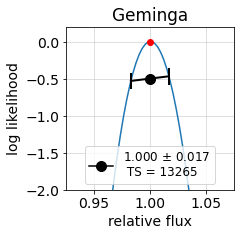 </figure></div>
<details open class="nbdoc-description" >  <summary> Parmeters from Poisson fit to full data set </summary>  <div style="margin-left: 25px;"><pre>flux                    1.0<br>ts                  13265.5<br>errors    (0.0171, -0.0169)<br>limit                1.0284<br>dtype: object<br></pre></div> </details>


In [10]:
#| code-fold: true
cells = None # global CellData object used below

@ipynb_doc
def load_cell_data(source_name='Geminga', weeks=(9,12), **kwargs) :
    """
    ## Study cell formation

    Set `config.full_exp=True` to get the energy-dependent exposure. Code that does is in `exposure.sc_data_selection`

    Load first 4 weeks.

    ### Load data
    {out1}
    {fig}
    {out2}
    """
    global cells
    
    with capture_hide(f'setup: load {weeks[1]-weeks[0]+1} weeks of data for source "{source_name}"') as out1:
        source = PointSource(source_name) #'Geminga')
        cells = CellData(source, config=Config(**kwargs), week_range=weeks,key=None)
    fig, ax = plt.subplots(figsize=(3,3))
    cells.plot_concatenated(ax=ax, title=source_name);
    with capture_show('Parmeters from Poisson fit to full data set') as out2:
        L = cells.full_likelihood()
        pr = PoissonRep(L)
        print(pd.Series(pr.info()))
    return locals()
if Config().valid:
    load_cell_data(use_kerr=False, full_exp=True, verbose=2)

### Exposure vs. energy

With the PSR J0633+1746 data, 
<details open class="nbdoc-description" >  <summary> Exposure Dataframe from "df.iloc[0]" </summary>  <div style="margin-left: 25px;"><pre>start                                             54682.656038<br>stop                                              54682.656375<br>livetime                                             25.041281<br>cos_theta                                             0.818062<br>exp                                              109091.398438<br>exp_fract    [0.10706, 0.1333, 0.2415, 0.2146, 0.162, 0.093...<br>Name: 0, dtype: object<br></pre></div> </details>
<details  class="nbdoc-description" >  <summary> Exposure dataframe info </summary>  <div style="margin-left: 25px;"><pre>&lt;class 'pandas.core.frame.DataFrame'&gt;<br>RangeIndex: 14835 entries, 0 to 14834<br>Data columns (total 6 columns):<br> #   Column     Non-Null Count  Dtype  <br>---  ------     --------------  -----  <br> 0   start      14835 non-null  float64<br> 1   stop       14835 non-null  float64<br> 2   livetime   14835 non-null  float32<br> 3   cos_theta  14835 non-null  float32<br> 4   exp        14835 non-null  float32<br> 5   exp_fract  14835 non-null  object <br>dtypes: float32(3), float64(2), object(1)<br>memory usage: 521.7+ KB<br>None<br></pre></div> </details>
Note the `exp_fract` values, which are the fraction of the total (`exp`) in each band.
<div style="margin-left: 25px"><figure style="margin-left: 25px" title="Figure 1">   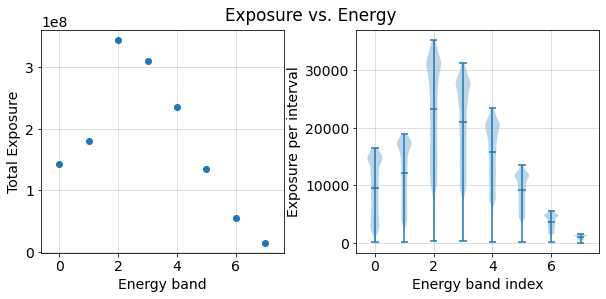 </figure></div>


In [11]:
#| code-fold: true
@ipynb_doc
def check_energy_exposure():
    """ ### Exposure vs. energy
    
    With the {name} data, 
    {out1}
    {out2}
    Note the `exp_fract` values, which are the fraction of the total (`exp`) in each band.
    {fig}
    """
    df = cells.exposure
    name =cells.source.name
    with capture_show('Exposure Dataframe from "df.iloc[0]"') as out1:
        print(df.iloc[0])
    with capture_hide('Exposure dataframe info') as out2:
        print(df.info())
    
    # generate array of the 8 
    t =df.apply(lambda r: np.array(r.exp * np.array(r.exp_fract), float), axis=1).values
    u = np.vstack(t)

    fig, (ax, ax2,) =plt.subplots(1,2, figsize=(10,4), sharex=True)
    plt.subplots_adjust(top=0.9, wspace=0.3)
    fig.suptitle('Exposure vs. Energy')
    ax.plot(u.sum(axis=0), 'o')
    ax.grid(alpha=0.5)
    ax.set(xlabel='Energy band', ylabel='Total Exposure')
    ax2.violinplot(u, np.arange(8), showmeans=True);
    ax2.grid(alpha=0.5)
    ax2.set(ylabel='Exposure per interval', xlabel='Energy band index')


    return locals()
if Config().valid:
    check_energy_exposure()

In [12]:
#| include: false
# df = cells.photons.copy()
# df.loc[:,'eindex'] = (df.band.values//2).astype(int)


# t = df.groupby('eindex').agg(
#     wcount = ('weight', len),
#     wsum = ('weight', np.sum), #column="B", aggfunc="min"
#     wsumsq =('weight', lambda x: np.sum(x**2))
# )

# t.loc[:,'unc'] = t.apply(lambda r: np.sqrt(r.wsumsq)/r.wsum, axis=1)
# t

### Weight sum vs. energy
The sum of weights is proportional to the flux.
Exmamine the photon energy dependence for PSR J0633+1746.

<details  class="nbdoc-description" >  <summary> Photon dataframe info </summary>  <div style="margin-left: 25px;"><pre>&lt;class 'pandas.core.frame.DataFrame'&gt;<br>RangeIndex: 6150 entries, 0 to 6149<br>Data columns (total 4 columns):<br> #   Column      Non-Null Count  Dtype  <br>---  ------      --------------  -----  <br> 0   band        6150 non-null   uint8  <br> 1   nest_index  6150 non-null   uint32 <br> 2   weight      6150 non-null   float64<br> 3   time        6150 non-null   float64<br>dtypes: float64(2), uint32(1), uint8(1)<br>memory usage: 126.2 KB<br>None<br></pre></div> </details>
<div style="margin-left: 25px"><figure style="margin-left: 25px" title="Figure 1">   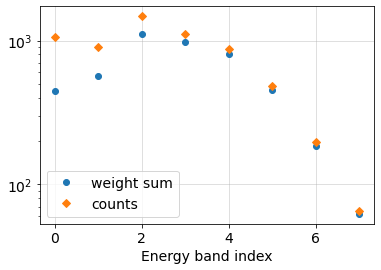 </figure></div>

### Check flux per energy band
Make the ratio of the sum of weights to exposure, a measure of the flux relative to the spectrum.
<details  class="nbdoc-description" >  <summary> Table of weights and Total exposure per band </summary>  <div style="margin-left: 25px;"><pre>         wtsum    exp  ratio<br>eindex                      <br>0        444.1  141.8   3.13<br>1        565.7  180.3   3.14<br>2       1101.0  344.6   3.20<br>3        972.1  310.5   3.13<br>4        809.2  235.3   3.44<br>5        452.6  135.2   3.35<br>6        185.3   54.7   3.39<br>7         62.2   14.7   4.24<br></pre></div> </details>

<div style="margin-left: 25px"><figure style="margin-left: 25px" title="Figure 2">   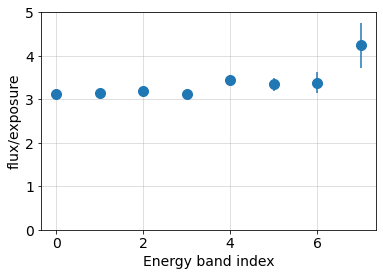 </figure></div>
Loods pretty good.


In [13]:
#| code-fold: true
@ipynb_doc
def flux_energy():
    """
    ### Weight sum vs. energy
    The sum of weights is proportional to the flux.
    Exmamine the photon energy dependence for {nickname}.
    
    {out1}
    {fig1}
    
    ### Check flux per energy band
    Make the ratio of the sum of weights to exposure, a measure of the flux relative to the spectrum.
    {out2}
    
    {fig2}
    Loods pretty good.
    """
    df = cells.photons.copy()
    name, nickname = cells.source.name, cells.source.nickname
    with capture_hide('Photon dataframe info') as out1:
        print(df.info())
    df.loc[:,'eindex'] = (df.band.values//2).astype(int)
    # plt.subplots_adjust(wspace=0.3)
    # ax.hist(df.eindex, np.linspace(-0.5,7.5,9), log=False, histtype='step', lw=2);
    # ax.set(xlabel='Energy index', ylim=(2,None));
    
    # get the moments of the weight per energy
    gb = df.groupby('eindex').agg(
            wcount = ('weight', len),
            wsum = ('weight', np.sum), #column="B", aggfunc="min"
            wsumsq =('weight', lambda x: np.sum(x**2))
        )

    gb.loc[:,'unc'] = gb.apply(lambda r: np.sqrt(r.wsumsq)/r.wsum, axis=1)
    # wtsums = gb.sum().weight.values

    fig1, ax1 = plt.subplots(1,1, figsize=(6,4))

    ax1.plot(gb.wsum.values, 'o', label='weight sum');
    ax1.plot(gb.wcount, 'D', label='counts');
    ax1.set(xlabel='Energy band index', yscale='log');
    ax1.legend(); ax1.grid(alpha=0.5)
    
    # get exposure vs enegy
    t =cells.exposure.apply(lambda r: np.array(r.exp * np.array(r.exp_fract), float), axis=1).values
    ee = np.vstack(t).sum(axis=0)*1e-6
    with capture_hide('Table of weights and Total exposure per band') as out2:
        dfx = pd.DataFrame(dict(wtsum=gb.wsum.round(1), exp=ee.round(1), ratio=(gb.wsum/ee).round(2)))
        print(dfx)
   
        
    fig2, ax2 = plt.subplots(1,1)
    ax2.set(ylim=(0,5), xlabel='Energy band index', ylabel='flux/exposure')
    ax2.grid(alpha=0.5)
    ratio = gb.wsum/ee
    ax2.errorbar(x=range(len(ratio)), y=ratio, yerr=ratio*gb.unc, fmt='o', ms=10)
    # ax2.plot(gb.wsum/ee, 'o');
    
    return locals()
if Config().valid:
    flux_energy()

In [14]:
#| include: false
# df = cells.photons.copy()
# name, nickname = cells.source.name, cells.source.nickname
# df.loc[:,'eindex'] = (df.band.values//2).astype(int)
# # get the moments of the weight per energy
# gb = df.groupby('eindex').agg(
#         wcount = ('weight', len),
#         wsum = ('weight', np.sum), #column="B", aggfunc="min"
#         wsumsq =('weight', lambda x: np.sum(x**2))
#     )

# gb.loc[:,'unc'] = gb.apply(lambda r: np.sqrt(r.wsumsq)/r.wsum, axis=1)

In [15]:
#| include: false
# #export
# def phase_cells(self, period, nbins):
#     """    
#     """
#     view = self.view(0,0, period/nbins)
#     cells = view.cells
#     bw = 1/nbins
    
#     def concat(pcells, t):
#         newcell = dict(t=t, tw=bw)

#         for col in 'n e S B'.split():
#             newcell[col] = pcells[col].sum()
#         newcell['w'] = np.concatenate(list(pcells.w.values))
#         return newcell
    
#     fcells = [concat(cells.iloc[ibin:-1:nbins], (ibin+0.5)*bw) for ibin in range(nbins) ]
         
#     return  pd.DataFrame(fcells)

# # hide
# ################################
# #  Develop folded cells
# ###############################
# source = PointSource('Vela pulsar')

# # photons, exposure = cd.photons.copy(), cd.exposure.copy()
# period, nbins = 53.05, 25



# z = phase_cells(CellData(source), period,nbins)
# z.head()

# # hide
# config=Config(use_kerr=True); config.verbose=2
# if config.valid:
#     source = PointSource('Geminga')

#     cd = CellData(source, config=config, week_range=(9,11),key=None)

#     cd.plot_concatenated( title=f'{cd.source.name}');
#     print('Parmeters from Poisson fit to full data set')
#     L = cd.full_likelihood()
#     pr = PoissonRep(L)
#     print(pd.Series(pr.info()))

# #(cd.cells.n/cd.cells.e).describe()

# # from wtlike.exposure import weighted_aeff
# sc_df = cells.exposure

# cos_theta = sc_df.cos_theta.values
# livetime = sc_df.livetime.values

# # func = weighted_aeff(config, source) 
# # sc_df.loc[:,'exp'] =
# exp = sc_df.exp.values #(func(cos_theta) * livetime).astype(np.float32)

# ef = sc_df.exp_fract
# efa = np.array([np.array(x,float) for x in ef])
# efe = efa.T * exp
# efe.sum(axis=0)

#     def get_exposure_per_cell(self, exposure_factor=1e-6):
#         """
#         Return a dict of arrays per cell:
#         - exp -- exposure, in cm^2 Ms units, if exposure_factor==1e-6
#         - costh -- mean cos theta per cell
#         - exp_energy if exp_fract in the exposure DF, set exposure energy
        
#         """
#         exp = self.exposure.exp.values
#         costh = self.exposure.cos_theta.values
#         # the cell index list  
#         eci = np.searchsorted(self.exposure.stop, self.cell_edges).reshape(len(self.cell_edges)//2,2)
#         cell_exp = np.array([exp[slice(*ecx)].sum()*exposure_factor for ecx in eci], np.float32) #np.float32)
#         cell_costh =np.array([costh[slice(*ecx)].mean() for ecx in eci], np.float32) #np.float32)
        
#         ef = self.exposure.get('exp_fract', False)
#         if ef is not None:
#             efa = np.array([np.array(x,float) for x in ef])
#             efe = efa.T * exp
#             cee = np.array([efe.T[slice(*ecx)].sum(axis=0)*exposure_factor for ecx in eci], np.float32)
#         else:
#             cee = None
#         return dict(exp=cell_exp, costh= cell_costh, exp_energy= cee)

# get_exposure_per_cell(cells)

# self = cd; exposure_factor=1e-6
# exp = self.exposure.exp.values

# eci = np.searchsorted(self.exposure.stop, self.cell_edges).reshape(len(self.cell_edges)//2,2)
# cell_exp = np.array([exp[slice(*ecx)].sum()*exposure_factor for ecx in eci], np.float32) #np.float32)

# cell_energy_exp = t = np.array([efe.T[slice(*ecx)].sum(axis=0)*exposure_factor for ecx in eci])
# t, t.sum(axis=1)-

## Temporary - check phased cells

In [16]:
#| include: false
from nbdev import nbdev_export
nbdev_export()
!date

Thu Mar  2 23:53:27 PST 2023
